# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


## TD5 : Méthodes Monte-Carlo par chaîne de Markov (MCMC)


Dans ce TD, nous implémenterons l'algorithme de Metropolis-Hastings et l'échantillonnage de Gibbs, deux méthodes Monte-Carlo par chaîne de Markov, permettant d'otenir un échantillon aléatoire à partir de la forme fonctionnelle d'un loi de probabilité. La lecture du chapitre 5 des notes de cours vous sera très utile.

In [2]:
# Chargement des librairies nécessaires
using CSV, DataFrames, Gadfly, Statistics, Distributions

## Exercice 1 : Génération d'un échantillon à l'aide de l'algorithme de Metropolis-Hastings

Dans cet exercice, nous génèrerons un échantillon de la loi de Student à 15 degrés de liberté avec l'algorithme de Metropolis-Hastings. Nous utiliserons une marche aléatoire symétrique comme loi de proposition des candidats. Le but de cet exercice consite à vous familiariser avec l'algorithme de Metropolis-Hastings.

Dans l'algorithme de Metropolis-Hastings, seulement la forme fonctionnelle de la loi est requise. Pour la loi de Student à 15 degrés de liberté, la forme fonctionnelle est la suivante :
$$g_Y(y) \propto \left( 1+\frac{y^2}{15} \right)^{-8}.$$


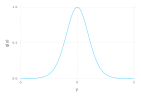

In [3]:
# Définition de la forme fonctionnelle de la loi de Student à 15 degrés de liberté
g(y::Real) = (1+(y^2)/15)^-8

# Affichage de la forme fonctionnelle
y = -5:.01:5
plot(x=y,y=g.(y),Geom.line, Guide.xlabel("y"), Guide.ylabel("g(y)"))

#### Définition de la loi de proposition des candidats.

Dans cet exercice, nous utiliserons la loi normale centrée et de variance 4 comme loi de proposition des candidats :

$$\delta \sim \mathcal{N}(0,2^2).$$

In [4]:
δ = Normal(0,2)

Normal{Float64}(μ=0.0, σ=2.0)

#### Initialisation de l'état de y

L'état initial de y est défini arbitrairement à -5.

In [5]:
# Initialisation de l'état de y à -5.

y = Float64[]
push!(y,-5)

1-element Vector{Float64}:
 -5.0

### (a) Proposez un candidat pour l'état suivant

Générez un candidat avec la loi de proposition des candidats. Avec une marche aléatoire, on fait un pas aléatoire depuis l'état présent. Donc générez un pas de la loi delta pour trouver le candidat dénoté $\tilde{y}$.

Une réalisation de $\delta$ peut être obetnue avec la commande `rand(δ)`. 

In [6]:
# Génération d'un pas aléatoire
d = rand(δ)

# Calcul du candidat correspondant
ỹ = y[end] + rand(δ)

-7.83430807895184

### (b) Calculez la probabilité ρ d'accepter le candidat ỹ.

Cette probabilité est donnée par l'équation suivante :

$$\rho = \min \left\{ \frac{g(\tilde{y})}{g(y)} , 1 \right\}. $$

In [7]:
ρ = minimum([g(ỹ)/g(y[end]), 1])

0.005659880059903364

### (c) Définir l'état suivant en fonction de ρ.

L'état suivant est défini comme suit :
$$y^{(1)} = \begin{cases} 
            \tilde{y} & \mbox{ avec probabilité } \rho ; \\
            y^{(0)} & \mbox{ avec probabilité } (1-\rho) .
             \end{cases}$$
             
Donc en fonction de $\rho$, définissez l'état suivant et ajoutez le à la fin du vecteur $y$ avec la fonction `push!`.

In [8]:
# Acceptez ou refusez le candidat pour définir l'état présent

if rand(Bernoulli(ρ))==1
    push!(y,ỹ)
else
    push!(y,y[end])
end

2-element Vector{Float64}:
 -5.0
 -5.0

### (d) Répétez les étapes (a) à (c) pour obtenir un vecteur y de taille 3000.

In [10]:
for i=3:3000

    # Génération d'un pas
    d = rand(δ)

    # Calcul le candidat correspondant
    ỹ = y[end] + rand(δ)
    
    ρ = minimum([g(ỹ)/g(y[end]), 1])
    
    if rand(Bernoulli(ρ))==1
        push!(y,ỹ)
    else
        push!(y,y[end])
    end
    
end



### (e) Tracez la chaîne générée et identifiez les phases de chauffe et d'échantillonnage.

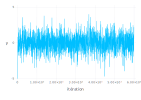

In [11]:
plot(x=1:length(y),y=y,Geom.line, Guide.xlabel("itération"))

### (f) Illustrez par un histogramme les itérations de la phase d'échantillonnage

Les itérations de la phase de chauffe peuvent être supprimées avec la fonction `deleteat!`. Par sécurité, éliminez les 500 premières itérations. Utilisez la géométrie `Geom.histogram(bincount=30)`de la fonction `plot` pour tracer l'histogramme.

In [12]:
deleteat!(y,1:500)

5498-element Vector{Float64}:
 -0.6532675928796638
 -0.6532675928796638
  0.3072699129614552
  0.3072699129614552
 -1.1070366678191816
 -1.1629343650858586
 -1.0773214261388797
 -0.23671910454440315
  0.008765604392192455
 -1.0944849296237784
 -0.8214965349811907
 -0.8214965349811907
  0.7260676377006323
  ⋮
  0.6894106206802149
 -0.9522708286834869
 -0.9522708286834869
  0.6558558533692451
  0.6558558533692451
  0.5557370276581297
  0.5557370276581297
  2.1480616741282184
  2.1480616741282184
  2.1480616741282184
  2.179777125822468
  2.179777125822468

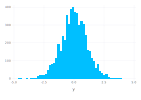

In [13]:
plot(x=y, Geom.histogram(bincount=50), Guide.xlabel("y"))

## Exercice 2 : Génération d'un échantillon aléatoire avec la fonction rwmh.

La fonction `rwmh` pour *random walk Metropolis-Hastings* permet de générer un échantillon aléatoire avec l'algorithme de Metropolis-Hastings utilisant une marche aléatoire comme loi de proposition des candidats. Cette fonction utilise une implémentation numériquement stable et computationnellement efficace de l'algorithme de Metropolis-Hastings. Elle requiert le *ln* de la forme fonctionnelle de la densité duquel l'échantillon est généré.

In [14]:
"""
    rwmh(logf::Function ; n::Int=1000, δ::UnivariateDistribution=Normal(0,1), initialvalue::Real=0.0, warmup::Int=0)

Génération d'un échantillon aléatoire avec l'algorithme de Metropolis-Hastings utilisant une marche aléatoire comme loi de proposition.

### Arguments
- `logf::Function` : fonction unidimensionnelle évaluant la forme fonctionnelle de la densité.
- `n::Int` : Nombre d'itérations de l'algorithme (n=1000 par défaut).
- `δ::UnivariateDistribution` : Une distribution symétrique et centrée en 0 permettant de générer les pas de la marche aléatoire. La loi normale centrée réduite est utilisée par défaut. 
- `initialvalue::Real` : L'état initial de la chaîne (0 par défaut.)
- `warmup::Int` : Le nombre d'itérations de la phase de chauffe à retirer (0 par défaut).

### Details

La fonctionne retourne la chaîne générée et un vecteur de booléens indicant si le candidat a été accepté ou refusé à chacune des itérations.

### Exemples

\```
 julia> chain, acc = rwmh(logf)
 julia> chain, acc = rwmh(logf ; n=3000, δ = TDist(5), initialvalue=-5, warmup::Int=500)
\```

"""
function rwmh(logf::Function ; n::Int=1000, δ::UnivariateDistribution=Normal(0,1), initialvalue::Real=0.0, warmup::Int=0)
    
    @assert mean(δ)==0.0 "The stepsize distribution should be centered at 0."
    @assert skewness(δ)==0.0 "The stepsize distribution should be symetrical."
    @assert warmup<n "The total number of iterations shoub be larger than the warm-up."
    
    y = zeros(n)
    acc = falses(n)
    
    y[1] = initialvalue
        
    d = rand(δ,n)
    
    log_u = log.(rand(n))
    
    for i=2:n
       
        ỹ = y[i-1] + d[i]
        
        log_ρ = logf(ỹ) - logf(y[i-1])
        
        if log_ρ > log_u[i]
            y[i] = ỹ
            acc[i] = true
        else
            y[i] = y[i-1]
        end
        
    end
    
    if warmup>0
        deleteat!(y,1:warmup)
        deleteat!(acc,1:warmup)
    end
    
    return y, acc
    
end

rwmh

### (a) Définissez la fonction du log de la forme fonctionnelle de la loi de Student à 15 degrés de liberté

In [15]:
logf(y::Real) = -8*log( 1 + (y^2)/15 ) 

logf (generic function with 1 method)

### (b) Générez un échantillon de taille 3000 avec la fonction `rwmh`en rejetant les 500 premières itérations.

In [16]:
y, acc = rwmh(logf, δ = Normal(0,2), n=3000, initialvalue = -5, warmup=500)

([1.0410269519890825, 1.0410269519890825, 1.0410269519890825, 1.0410269519890825, 1.2862339130756413, 2.2320446811181998, -2.2760070796196987, -2.2760070796196987, -1.44153440262604, -1.362191613882916  …  1.501812494997412, 1.501812494997412, 0.11583029347679519, 0.11583029347679519, 0.11583029347679519, 0.11583029347679519, 0.11583029347679519, 0.11583029347679519, 0.7423292585106263, -0.16903211131012597], Bool[1, 0, 0, 0, 1, 1, 1, 0, 1, 1  …  0, 0, 1, 0, 0, 0, 0, 0, 1, 1])

### (c) Calculez le taux d'acceptation des candidats

In [17]:
acc_rate = mean(acc)

0.5144

### (d) Affichez la chaîne résultante et l'histogramme

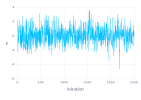

In [18]:
plot(x=1:length(y), y=y, Geom.line, Guide.xlabel("itération"))

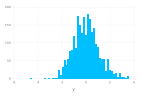

In [19]:
nbin = round(sqrt(length(y)))
plot(x=y, Geom.histogram(bincount=nbin), Guide.xlabel("y"))

## Exercice 3 : Expérience de Michelson-Morley (avec variance connue)

On a que

$$ Y_i \sim \mathcal{N} \left( \mu, \sigma^2 \right) ; $$

avec la variance est connue et égale à $\sigma^2 = (0.75)^2$. On utilise la loi *a priori* suivante pour $\mu$ inconnu :

$$f_{\mu}(\mu) = t_5(0,\sigma) ; $$

qui correspond à la loi de Student à 5 degrés de liberté, de moyenne 0 et de paramètre d'échelle $\sigma$.

Puisque la loi de Student n'est pas conjuguée, la loi *a posteriori* ne s'exprime pas sous une forme analytique. Par conséquent, nous utiliserons l'algorithme de Metropolis-Hastings pour obtenir un échantillon de la loi *a posteriori*.

In [20]:
# Chargement des données
data = CSV.read("illingworth1927.csv", DataFrame)

df = filter(row -> (row.Time == "5 a.m.") & (row.Direction =="N"), data )
y = df[:,:FringeDispl]

# Définition de l'écart-type de l'erreur de mesure
σ = 3/2

1.5

### (a) Écrivez la log-vraisemblance

Écrivez la log-vraisemblance de l'échantillon aléatoire comme une fonction de $\mu$. Pour ce faire, la fonction `loglikelihood` peut être très utile. Évaluez ensuite la log-vraisemblance au point $\mu=0$.

In [27]:
logL(μ::Real) = loglikelihood(Normal(μ,σ),y)
logL(0)

-8.348021847877023

### (b) Écrivez la log-densité de la loi *a priori*.

Écrivez la log-densité de la loi *a priori* de $\mu$ comme une fonction de $\mu$. Pour définir un objet *Distribution* de type loi de Student à 5 degrés de liberté de moyenne 0 et d'échelle $\sigma$, vous pouvez utiliser la commande `LocationScale(0,σ,TDist(5))` qui ajoute un paramètre de localisation et de forme à la loi de Student. La log-densité peut être obtenue avec la fonction `logpdf`. Évaluez ensuite la log-densité de la loi *a priori* au point $\mu=0$.

In [28]:
pd = LocationScale(0,3/4,TDist(5))
logprior(μ::Real) = logpdf(pd, μ)
logprior(0)

-0.6809375166029432

### (c) Écrivez le log de la forme fonctionnelle de la loi *a posteriori*. 

Écrivez le log de la forme fonctionnelle de la loi *a posteriori* comme une fonction de $\mu$. Évaluez ensuide cette fonction au point $\mu=0$.

In [29]:
logf(μ::Real) = logL(μ) + logprior(μ)
logf(0)

-9.028959364479967

### (d) Générez un échantillon de la loi *a posteriori*.

Utilisez le log de la forme fonctionnelle de la loi *a posteriori* dans la fonction `rwmh` pour générer un échantillon de cette loi. Assurez-vous que le taux d'acceptation des candidats est entre 40% et 70%.

In [30]:
μ,acc = rwmh(logf,δ = Normal(0,1), n=3000, initialvalue = 0, warmup=500)

tauxAcc = mean(acc)


0.4736

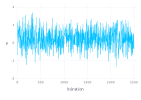

In [31]:
plot(x=1:length(μ),y=μ,Geom.line, Guide.xlabel("itération"))

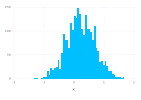

In [32]:
nbin = round(sqrt(length(μ)))
plot(x=μ,Geom.histogram(bincount=nbin))

### (e) Obtenez une estimation ponctuelle de $\mu$.

À l'aide de l'échantillon aléatoire obtenu, obtenez une estimation ponctuelle de $\mu$.

In [33]:
# Première option : la moyenne de la loi a posteriori (estimée par Monte-Carlo)
μ̂ = mean(μ)

0.22202121532624897

In [34]:
# Deuxième option : le mode de la loi a posteriori (estimé par Monte-Carlo)
ind = argmax(logf.(μ))
μ̂ = μ[ind]

0.20522186133666626